https://huggingface.co/nvidia/segformer-b5-finetuned-cityscapes-1024-1024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installs

In [ ]:
!pip install pytorch_lightning
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 700 kB 6.9 MB/s 
     |████████████████████████████████| 419 kB 52.9 MB/s 
     |████████████████████████████████| 5.8 MB 43.5 MB/s 
     |████████████████████████████████| 596 kB 73.5 MB/s 
     |████████████████████████████████| 141 kB 27.6 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.9.1 which is inco

#Imports

In [ ]:
import datetime

import collections as cl

import cv2

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

from PIL import Image, ImageShow, ImageDraw
from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Function, Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
from torchvision import transforms, utils
import torchvision.models as models

from typing import Optional

import json

import os
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# SegFormer raw (для просмотра работы модели вручную)

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model.train()
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

image = Image.open('drive/MyDrive/Дипломный проект/datasets/aug_data/test/23429080_15.png_0.png').convert('RGB')
mask = Image.open('drive/MyDrive/Дипломный проект/datasets/aug_data/test_labels/23429080_15.png_0.png').convert('RGB')

inputs = feature_extractor(images=image, return_tensors="pt", reduce_labels=True)
mask = feature_extractor(images=mask, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

In [ ]:
print(logits)

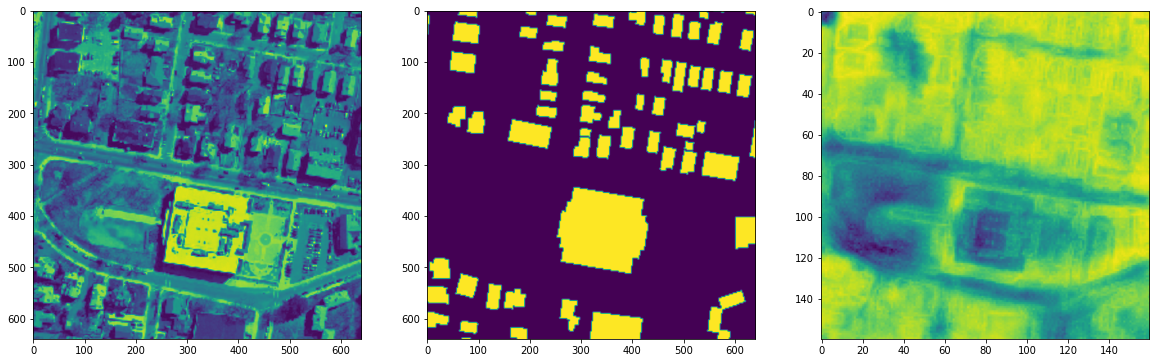

In [ ]:
f, axis = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(20)

axis[0].set_label('True image')
axis[1].set_label('True mask')
axis[2].set_label('Predicted mask')

axis[0].imshow(inputs['pixel_values'][0][0].detach())
axis[1].imshow(mask['pixel_values'][0][0].detach())
axis[2].imshow(logits[0][1].detach().cpu());

# Downloading and resizing photos

In [ ]:
# !mkdir mas_data

# !cp -r drive/MyDrive/'Дипломный проект'/datasets/mas-roofs/* mas_data

In [ ]:
# !rm -r mas_data/mas-roofs/*/.ipynb_checkpoints

rm: cannot remove 'mas_data/mas-roofs/*/.ipynb_checkpoints': No such file or directory


# Helpers

In [ ]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

#PytorchLightning classes

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 30

date = datetime.datetime.today()
date = date.date()

In [ ]:
# DATA_DIR = 'drive/MyDrive/Дипломный проект/datasets/mas-roofs/' # Massachusetts dataset
# DATA_DIR = 'data' # my dataset
DATA_DIR = 'drive/MyDrive/Дипломный проект/datasets/aug_data/' # augmenteted Massachusetts dataset

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
class AutoModelSegFormer(pl.LightningModule):

    def __init__(self,
                 learning_rate: float = 1e-4,
                 ):
        
        super(AutoModelSegFormer, self).__init__()
        # self.model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
        self.model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

        self.model.decode_head.classifier = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
        self.save_hyperparameters("learning_rate")

        # self.init_weights()


    # def init_weights(self) -> None:
    #     initrange = 0.1
    #     self.model.decode_head.classifier.weight.data.uniform_(-initrange, initrange)


    def forward(self, x):
        outputs = self.model(**x)
        logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

        return logits


    def training_step(self, batch, batch_idx):
        x = batch['image']
        y = batch['mask']
        y_hat = self(x)

        train_loss = F.cross_entropy(y_hat, y, reduction="mean")
        # print(train_loss, '-train')

        return train_loss


    def validation_step(self, batch, batch_idx):
        x = batch['image']
        y = batch['mask']
        y_hat = self(x)

        val_loss = F.cross_entropy(y_hat, y, reduction="mean")

        return val_loss


    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x for x in outputs]).mean()
        self.log('val_loss', avg_loss, prog_bar=True)
        return avg_loss 


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

        return optimizer

In [ ]:
class SegFormerDataset(torch.utils.data.Dataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        # self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
        self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    
    def __getitem__(self, i):
        if isinstance(i, slice):
            output = cl.defaultdict(list)
            for i in range(i.start, i.stop):
                for key, value in self[i].items():
                    output[key].append(value)
            for key, value in output.items():
                output[key] = torch.stack(value)
            return output
        
        # image = Image.open(self.image_paths[i]).convert('RGB')
        # mask = Image.open(self.mask_paths[i]).convert('RGB')

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        image = self.feature_extractor(images=image, return_tensors="pt")
        mask = self.feature_extractor(images=mask, return_tensors="pt")

        image["pixel_values"] = image["pixel_values"][0]
        mask["pixel_values"] = mask["pixel_values"][0]

        #reshaping mask
        # transform = T.Resize((160,160)) # for segformer b5
        transform = T.Resize((128,128)) # for segformer b0

        reshaped_mask = transform(mask['pixel_values'])

        true_mask = reshaped_mask > -1.0
        true_mask = torch.tensor(true_mask, dtype=torch.long) #long)
        # true_mask[true_mask == 0] = 0 # 94 - задний фон для датасета 20К
        # true_mask[true_mask == 1] = 1 # 1 - здания

        return {
            "image": image, 
            "mask": true_mask[0]
            }
        
    def __len__(self):
        return len(self.image_paths)

In [ ]:
class SegFormerDataModule(pl.LightningDataModule):
    def __init__(self, 
                 batch_size: int = 4):
        
        super().__init__()
        self.batch_size = batch_size

    def insert_data(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, drop_last=True)

# Train model

In [ ]:
train_dataset = SegFormerDataset(
    x_train_dir, y_train_dir,
)

valid_dataset = SegFormerDataset(
    x_valid_dir, y_valid_dir
)
data_loaders = SegFormerDataModule(batch_size=BATCH_SIZE)
data_loaders.insert_data(train_dataset, valid_dataset)

In [ ]:
# data_transforms = transforms.Compose([transforms.ToTensor()])
model = AutoModelSegFormer(learning_rate=LEARNING_RATE)

trainer = pl.Trainer(
    # gpus=-1,
    auto_lr_find=False,
    val_check_interval=0.5,
    log_every_n_steps=1,
    max_epochs=EPOCHS,
)

# lr_finder = trainer.tuner.lr_find(model=model,
#                                   datamodule=data_loaders,
#                                   num_training=25,
#                                   max_lr=5e-4)
# fig = lr_finder.plot(suggest=True)
# fig.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training model

In [ ]:
# model.hparams.learning_rate = lr_finder.suggestion()

trainer.fit(model, data_loaders)

Missing logger folder: /content/lightning_logs

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M 
-----------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.save_checkpoint(f"segmodel_{date}.ckpt")

In [ ]:
os.system(f'cp segmodel_{date}.ckpt "drive/MyDrive/Дипломный проект/trained models/segmodel_{date}.ckpt"')

# Test trained model

In [ ]:
model_ckpt_path = f'segmodel_{date}.ckpt'

if not os.path.exists(model_ckpt_path):
    model_ckpt_path = f'drive/MyDrive/Дипломный проект/trained models/segmodel_{date}.ckpt'

model = AutoModelSegFormer.load_from_checkpoint(model_ckpt_path)
# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model_name = model_ckpt_path.split('_')[0]
print(f'Loaded {model_name} model from this run.')

Loaded segmodel model from this run.


In [ ]:
image = Image.open('drive/MyDrive/Дипломный проект/datasets/aug_data/test/23429080_15.png_0.png').convert('RGB')
mask = Image.open('drive/MyDrive/Дипломный проект/datasets/aug_data/test_labels/23429080_15.png_0.png').convert('RGB')

image = feature_extractor(images=image, return_tensors="pt", reduce_labels=True)
mask = feature_extractor(images=mask, return_tensors="pt")

#reshaping mask
transform = T.Resize((128,128))
reshaped_mask = transform(mask['pixel_values'])
# reshaped_mask = reshaped_mask[0][0]

true_mask = reshaped_mask > -2.117
true_mask = torch.tensor(true_mask, dtype=torch.long)
# print(true_mask[0], true_mask[1], true_mask[2])

In [ ]:
logits = model(image)
# pred_seg = transform_logits(logits)

In [ ]:
print(logits)

tensor([[[[ 0.4364,  0.6281,  1.5112,  ..., -1.3817, -1.1703, -0.9790],
          [ 0.4163,  0.6953,  1.6402,  ..., -0.6779, -0.3598, -0.3504],
          [ 0.3886,  0.8549,  1.8698,  ...,  0.5727,  0.9605,  0.9174],
          ...,
          [ 1.5719,  1.2841,  1.4224,  ...,  2.1438,  2.0956,  1.6945],
          [ 1.3912,  1.1677,  1.0913,  ...,  2.1350,  2.0399,  1.5533],
          [ 1.5997,  1.7195,  1.5203,  ...,  2.2357,  2.1848,  1.6210]],

         [[-0.2909, -0.4943, -1.4343,  ...,  1.7118,  1.6830,  1.5882],
          [-0.3823, -0.6760, -1.5771,  ...,  1.2452,  1.0891,  1.0850],
          [-0.4283, -0.7909, -1.7998,  ...,  0.2491, -0.0088, -0.0785],
          ...,
          [-1.0493, -0.9294, -1.0252,  ..., -2.4711, -2.0963, -1.9392],
          [-1.0461, -0.9510, -0.9617,  ..., -2.3624, -1.9899, -1.8425],
          [-1.3880, -1.3392, -1.1441,  ..., -2.3144, -2.1536, -1.9526]]]],
       grad_fn=<ConvolutionBackward0>)


In [ ]:
logits.argmax(dim=1)[0].unique()


tensor([0, 1])

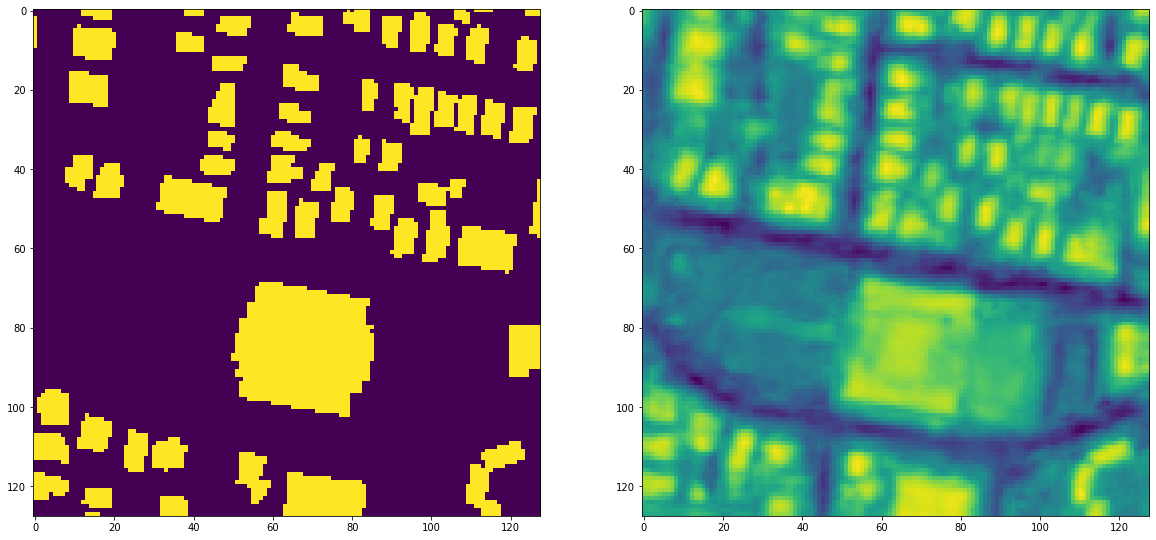

In [ ]:
f, axis = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(20)

axis[0].set_label('True mask')
axis[1].set_label('Predicted mask')

axis[0].imshow(true_mask[0][0].detach())
axis[1].imshow(logits[0][1].detach()); # logits[batch][class] - class 1 - buildings, 94 - ground